In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio
# from astropy.io import fits

from scipy import stats
from IPython.display import Image

sys.path.append(os.path.expanduser('~/git/Python/user_modules/'))
from match_coord import match_coord

import select_desi_targets

In [2]:
params = {'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize': 'large',
          'xtick.labelsize': 'large',
          'ytick.labelsize': 'large',
          'figure.facecolor': 'w'}
plt.rcParams.update(params)

In [3]:
ramin, ramax, decmin, decmax = 147.8+1.2, 152.5-1.2, -0.1+1.2, 4.5-1.2
nmad = lambda x: 1.4826*np.nanmedian(np.abs(x-np.nanmedian(x)))

In [4]:
truth = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/imaging_mc/subsets/cosmos_truth_clean.fits'))
print(len(truth))

# Remove objects with large sky residuals
for band in ['g', 'r', 'i', 'z']:
    truth[band+'_sky'] = (truth['apflux_blobresid_'+band][:, -1]-truth['apflux_blobresid_'+band][:, -2]) / (np.pi*7**2-np.pi*5**2)
mask = (truth['g_sky']>-0.002) & (truth['g_sky']<0.002)
print(np.sum(mask)/len(mask))
mask &= (truth['r_sky']>-0.003) & (truth['r_sky']<0.003)
print(np.sum(mask)/len(mask))
mask &= (truth['z_sky']>-0.006) & (truth['z_sky']<0.006)
print(np.sum(mask)/len(mask))
truth = truth[mask]
print(len(truth))

# Only keep isolated sources
mask = (truth['fracflux_g']>-0.01) & (truth['fracflux_g']<0.01)
print(np.sum(mask)/len(mask))
mask &= (truth['fracflux_r']>-0.01) & (truth['fracflux_r']<0.01)
print(np.sum(mask)/len(mask))
mask &= (truth['fracflux_z']>-0.01) & (truth['fracflux_z']<0.01)
print(np.sum(mask)/len(mask))
truth = truth[mask]
print(len(truth))

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    truth['gmag'] = 22.5 - 2.5*np.log10(truth['flux_g']) - 3.214 * truth['ebv']
    truth['rmag'] = 22.5 - 2.5*np.log10(truth['flux_r']) - 2.165 * truth['ebv']
    truth['zmag'] = 22.5 - 2.5*np.log10(truth['flux_z']) - 1.211 * truth['ebv']
    truth['w1mag'] = 22.5 - 2.5*np.log10(truth['flux_w1']) - 0.184 * truth['ebv']
    truth['w2mag'] = 22.5 - 2.5*np.log10(truth['flux_w2']) - 0.113 * truth['ebv']
    truth['gmagerr'] = 1/np.sqrt(truth['flux_ivar_g'])/(truth['flux_g'])
    truth['rmagerr'] = 1/np.sqrt(truth['flux_ivar_r'])/(truth['flux_r'])
    truth['zmagerr'] = 1/np.sqrt(truth['flux_ivar_z'])/(truth['flux_z'])
    truth['w1magerr'] = 1/np.sqrt(truth['flux_ivar_w1'])/(truth['flux_w1'])
    truth['w2magerr'] = 1/np.sqrt(truth['flux_ivar_w2'])/(truth['flux_w2'])
    truth['gfibermag'] = 22.5 - 2.5*np.log10(truth['fiberflux_g']) - 3.214 * truth['ebv']
    truth['rfibermag'] = 22.5 - 2.5*np.log10(truth['fiberflux_r']) - 2.165 * truth['ebv']
    truth['zfibermag'] = 22.5 - 2.5*np.log10(truth['fiberflux_z']) - 1.211 * truth['ebv']

truth_all = truth.copy()

1149893
0.9835628184535431
0.9732009847872802
0.9615285943996529
1105655
0.12092017853670449
0.09708724692603027
0.07313583351045308
80863


In [5]:
subs = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/data/deep_field_subsets/catalogs/cosmos_subsets_rongpu_dr10.fits'))
print(len(subs))

min_nobs = 1
mask = (subs['ngood_g']>=min_nobs) & (subs['ngood_r']>=min_nobs) & (subs['ngood_z']>=min_nobs)
subs = subs[mask]
print(len(subs))

tmp = Table()
tmp['sub'], tmp['count'] = np.unique(subs['sub'], return_counts=True)
tmp

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    subs['gmag'] = 22.5 - 2.5*np.log10(subs['flux_g']) - 3.214 * subs['ebv']
    subs['rmag'] = 22.5 - 2.5*np.log10(subs['flux_r']) - 2.165 * subs['ebv']
    subs['zmag'] = 22.5 - 2.5*np.log10(subs['flux_z']) - 1.211 * subs['ebv']
    subs['w1mag'] = 22.5 - 2.5*np.log10(subs['flux_w1']) - 0.184 * subs['ebv']
    subs['w2mag'] = 22.5 - 2.5*np.log10(subs['flux_w2']) - 0.113 * subs['ebv']
    subs['gmagerr'] = 1/np.sqrt(subs['flux_ivar_g'])/(subs['flux_g'])
    subs['rmagerr'] = 1/np.sqrt(subs['flux_ivar_r'])/(subs['flux_r'])
    subs['zmagerr'] = 1/np.sqrt(subs['flux_ivar_z'])/(subs['flux_z'])
    subs['w1magerr'] = 1/np.sqrt(subs['flux_ivar_w1'])/(subs['flux_w1'])
    subs['w2magerr'] = 1/np.sqrt(subs['flux_ivar_w2'])/(subs['flux_w2'])
    subs['gfibermag'] = 22.5 - 2.5*np.log10(subs['fiberflux_g']) - 3.214 * subs['ebv']
    subs['rfibermag'] = 22.5 - 2.5*np.log10(subs['fiberflux_r']) - 2.165 * subs['ebv']
    subs['zfibermag'] = 22.5 - 2.5*np.log10(subs['fiberflux_z']) - 1.211 * subs['ebv']

3183343
2752104


-------

sub-5


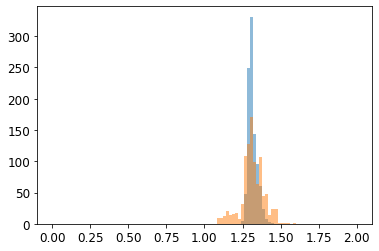

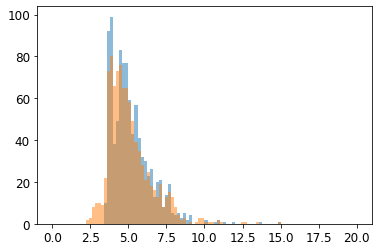

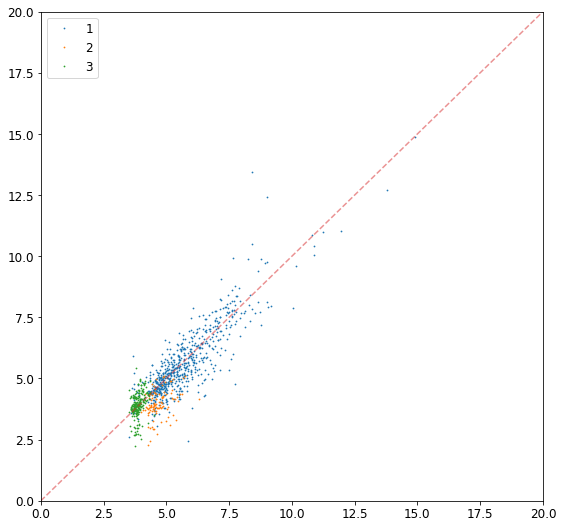

In [34]:
subset_index = 5
    
print('sub-{}'.format(subset_index))

truth = truth_all.copy()

mask = subs['sub']=='sub-{}'.format(subset_index)
sub = subs[mask].copy()
# print(len(sub))

idx1, idx2, d2d, d_ra, d_dec = match_coord(truth['ra'], truth['dec'], sub['ra'], sub['dec'], search_radius=0.5, plot_q=False, verbose=False)

truth = truth[idx1]
sub = sub[idx2]


# Use a different subset to select an unbiased ELG sample
mask = subs['sub']=='dr9_ccds'
sub1 = subs[mask].copy()
# print(len(sub1))
sub1_elglop, sub1_elgvlo = select_desi_targets.select_elgs(sub1)

idx1, idx2, d2d, d_ra, d_dec = match_coord(sub1['ra'], sub1['dec'], truth['ra'], truth['dec'], search_radius=0.5, plot_q=False, verbose=False)
elglop = np.in1d(np.arange(len(truth)), idx2[sub1_elglop[idx1]])
elgvlo = np.in1d(np.arange(len(truth)), idx2[sub1_elgvlo[idx1]])
# print(np.sum(elglop), np.sum(elgvlo))

mask0 = elglop.copy()

plt.hist(truth['psfsize_g'][mask0], 100, alpha=0.5, range=(0, 2))
plt.hist(sub['psfsize_g'][mask0], 100, alpha=0.5, range=(0, 2))
plt.show()

plt.hist(truth['blob_nea_g'][mask0], 100, alpha=0.5, range=(0, 20))
plt.hist(sub['blob_nea_g'][mask0], 100, alpha=0.5, range=(0, 20))
plt.show()

mask0 = elglop.copy()
# mask0 &= sub['gfibermag']>23.5
mask1 = mask0 & (sub['type']!='PSF')
mask2 = mask0 & (sub['type']=='PSF') & (truth['type']!='PSF')
mask3 = mask0 & (sub['type']=='PSF') & (truth['type']=='PSF')

plt.figure(figsize=(9, 9))
plt.plot(truth['blob_nea_g'][mask1], sub['blob_nea_g'][mask1], '.', ms=1.5, label='1')
plt.plot(truth['blob_nea_g'][mask2], sub['blob_nea_g'][mask2], '.', ms=1.5, label='2')
plt.plot(truth['blob_nea_g'][mask3], sub['blob_nea_g'][mask3], '.', ms=1.5, label='3')
plt.legend(loc='upper left', markerscale=3)
plt.plot(np.linspace(0, 100), np.linspace(0, 100), 'C3--', alpha=0.5)
plt.axis([0, 20, 0, 20])
plt.show()

sub-7


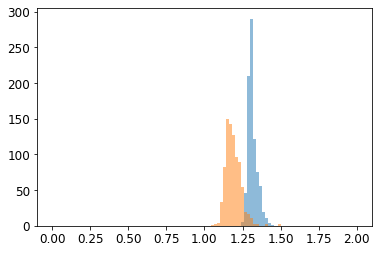

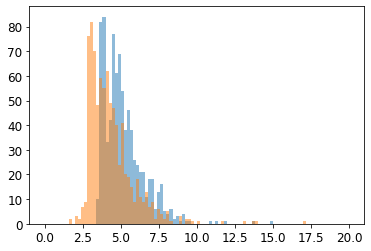

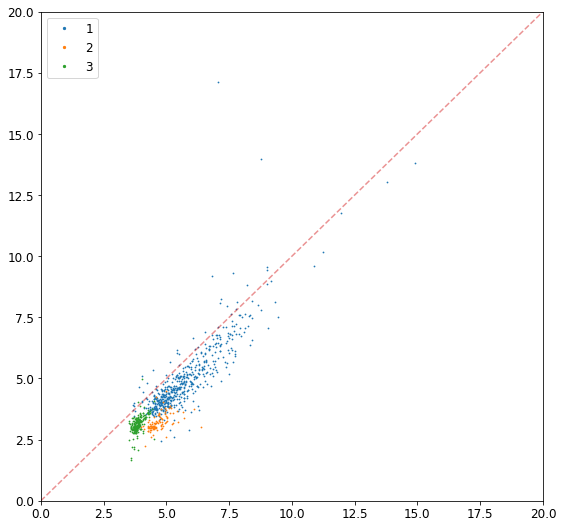

In [36]:
subset_index = 7

print('sub-{}'.format(subset_index))

truth = truth_all.copy()

mask = subs['sub']=='sub-{}'.format(subset_index)
sub = subs[mask].copy()
# print(len(sub))

idx1, idx2, d2d, d_ra, d_dec = match_coord(truth['ra'], truth['dec'], sub['ra'], sub['dec'], search_radius=0.5, plot_q=False, verbose=False)

truth = truth[idx1]
sub = sub[idx2]


# Use a different subset to select an unbiased ELG sample
mask = subs['sub']=='dr9_ccds'
sub1 = subs[mask].copy()
# print(len(sub1))
sub1_elglop, sub1_elgvlo = select_desi_targets.select_elgs(sub1)

idx1, idx2, d2d, d_ra, d_dec = match_coord(sub1['ra'], sub1['dec'], truth['ra'], truth['dec'], search_radius=0.5, plot_q=False, verbose=False)
elglop = np.in1d(np.arange(len(truth)), idx2[sub1_elglop[idx1]])
elgvlo = np.in1d(np.arange(len(truth)), idx2[sub1_elgvlo[idx1]])
# print(np.sum(elglop), np.sum(elgvlo))

mask0 = elglop.copy()

plt.hist(truth['psfsize_g'][mask0], 100, alpha=0.5, range=(0, 2))
plt.hist(sub['psfsize_g'][mask0], 100, alpha=0.5, range=(0, 2))
plt.show()

plt.hist(truth['blob_nea_g'][mask0], 100, alpha=0.5, range=(0, 20))
plt.hist(sub['blob_nea_g'][mask0], 100, alpha=0.5, range=(0, 20))
plt.show()

mask0 = elglop.copy()
# mask0 &= sub['gfibermag']>23.5
mask1 = mask0 & (sub['type']!='PSF')
mask2 = mask0 & (sub['type']=='PSF') & (truth['type']!='PSF')
mask3 = mask0 & (sub['type']=='PSF') & (truth['type']=='PSF')

plt.figure(figsize=(9, 9))
plt.plot(truth['blob_nea_g'][mask1], sub['blob_nea_g'][mask1], '.', ms=1.5, label='1')
plt.plot(truth['blob_nea_g'][mask2], sub['blob_nea_g'][mask2], '.', ms=1.5, label='2')
plt.plot(truth['blob_nea_g'][mask3], sub['blob_nea_g'][mask3], '.', ms=1.5, label='3')
plt.legend(loc='upper left', markerscale=3)
plt.plot(np.linspace(0, 100), np.linspace(0, 100), 'C3--', alpha=0.5)
plt.axis([0, 20, 0, 20])
plt.show()

sub-9


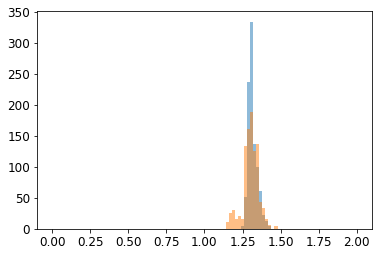

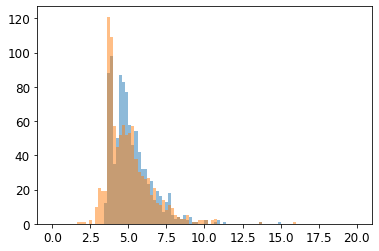

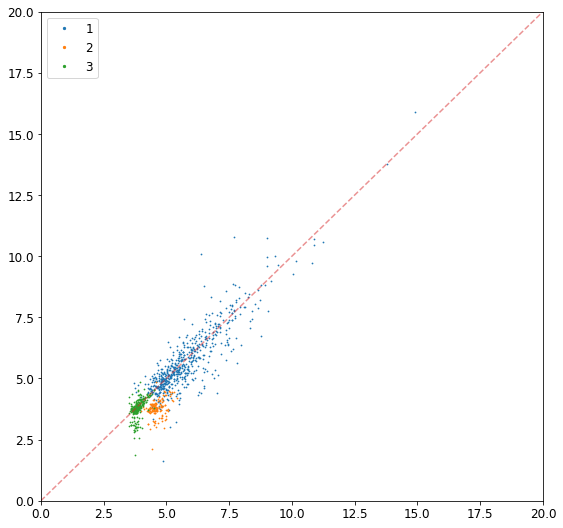

In [37]:
subset_index = 9

print('sub-{}'.format(subset_index))

truth = truth_all.copy()

mask = subs['sub']=='sub-{}'.format(subset_index)
sub = subs[mask].copy()
# print(len(sub))

idx1, idx2, d2d, d_ra, d_dec = match_coord(truth['ra'], truth['dec'], sub['ra'], sub['dec'], search_radius=0.5, plot_q=False, verbose=False)

truth = truth[idx1]
sub = sub[idx2]


# Use a different subset to select an unbiased ELG sample
mask = subs['sub']=='dr9_ccds'
sub1 = subs[mask].copy()
# print(len(sub1))
sub1_elglop, sub1_elgvlo = select_desi_targets.select_elgs(sub1)

idx1, idx2, d2d, d_ra, d_dec = match_coord(sub1['ra'], sub1['dec'], truth['ra'], truth['dec'], search_radius=0.5, plot_q=False, verbose=False)
elglop = np.in1d(np.arange(len(truth)), idx2[sub1_elglop[idx1]])
elgvlo = np.in1d(np.arange(len(truth)), idx2[sub1_elgvlo[idx1]])
# print(np.sum(elglop), np.sum(elgvlo))

mask0 = elglop.copy()

plt.hist(truth['psfsize_g'][mask0], 100, alpha=0.5, range=(0, 2))
plt.hist(sub['psfsize_g'][mask0], 100, alpha=0.5, range=(0, 2))
plt.show()

plt.hist(truth['blob_nea_g'][mask0], 100, alpha=0.5, range=(0, 20))
plt.hist(sub['blob_nea_g'][mask0], 100, alpha=0.5, range=(0, 20))
plt.show()

mask0 = elglop.copy()
# mask0 &= sub['gfibermag']>23.5
mask1 = mask0 & (sub['type']!='PSF')
mask2 = mask0 & (sub['type']=='PSF') & (truth['type']!='PSF')
mask3 = mask0 & (sub['type']=='PSF') & (truth['type']=='PSF')

plt.figure(figsize=(9, 9))
plt.plot(truth['blob_nea_g'][mask1], sub['blob_nea_g'][mask1], '.', ms=1.5, label='1')
plt.plot(truth['blob_nea_g'][mask2], sub['blob_nea_g'][mask2], '.', ms=1.5, label='2')
plt.plot(truth['blob_nea_g'][mask3], sub['blob_nea_g'][mask3], '.', ms=1.5, label='3')
plt.legend(loc='upper left', markerscale=3)
plt.plot(np.linspace(0, 100), np.linspace(0, 100), 'C3--', alpha=0.5)
plt.axis([0, 20, 0, 20])
plt.show()